Deep Learning Models -- A collection of various deep learning architectures, models, and tips for TensorFlow and PyTorch in Jupyter Notebooks.
- Author: Sebastian Raschka
- GitHub Repository: https://github.com/rasbt/deeplearning-models

In [1]:
!pip install -q IPython
!pip install -q ipykernel
!pip install -q watermark
!pip install -q matplotlib
!pip install -q sklearn
!pip install -q pandas
!pip install -q pydot
!pip install -q hiddenlayer
!pip install -q graphviz

In [2]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -v -p torch

Sebastian Raschka 

CPython 3.6.9
IPython 5.5.0

torch 1.5.1+cu101


- Runs on CPU or GPU (if available)

# Model Zoo -- Convolutional ResNet and Residual Blocks

Please note that this example does not implement a really deep ResNet as described in literature but rather illustrates how the residual blocks described in He et al. [1] can be implemented in PyTorch.

- [1] He, Kaiming, et al. "Deep residual learning for image recognition." *Proceedings of the IEEE conference on computer vision and pattern recognition*. 2016.

## Imports

In [3]:
import time
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

## Settings and Dataset

In [4]:
##########################
### SETTINGS
##########################

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
random_seed = 123
learning_rate = 0.01
num_epochs = 10
batch_size = 128

# Architecture
num_classes = 10


##########################
### MNIST DATASET
##########################

# Note transforms.ToTensor() scales input images
# to 0-1 range
train_dataset = datasets.MNIST(root='data', 
                               train=True, 
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='data', 
                              train=False, 
                              transform=transforms.ToTensor())


train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size, 
                         shuffle=False)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!



Image batch dimensions: torch.Size([128, 1, 28, 28])
Image label dimensions: torch.Size([128])


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


## ResNet with identity blocks

The following code implements the residual blocks with skip connections such that the input passed via the shortcut matches the dimensions of the main path's output, which allows the network to learn identity functions. Such a residual block is illustrated below:

![](https://github.com/DeepSE/deeplearning-models/blob/master/pytorch_ipynb/images/resnets/resnet-ex-1-1.png?raw=1)

In [5]:
##########################
### MODEL
##########################



class ConvNet(torch.nn.Module):

    def __init__(self, num_classes):
        super(ConvNet, self).__init__()
        
        #########################
        ### 1st residual block
        #########################
        # 28x28x1 => 28x28x4
        self.conv_1 = torch.nn.Conv2d(in_channels=1,
                                      out_channels=4,
                                      kernel_size=(1, 1),
                                      stride=(1, 1),
                                      padding=0)
        self.conv_1_bn = torch.nn.BatchNorm2d(4)
                                    
        # 28x28x4 => 28x28x1
        self.conv_2 = torch.nn.Conv2d(in_channels=4,
                                      out_channels=1,
                                      kernel_size=(3, 3),
                                      stride=(1, 1),
                                      padding=1)   
        self.conv_2_bn = torch.nn.BatchNorm2d(1)
        
        
        #########################
        ### 2nd residual block
        #########################
        # 28x28x1 => 28x28x4
        self.conv_3 = torch.nn.Conv2d(in_channels=1,
                                      out_channels=4,
                                      kernel_size=(1, 1),
                                      stride=(1, 1),
                                      padding=0)
        self.conv_3_bn = torch.nn.BatchNorm2d(4)
                                    
        # 28x28x4 => 28x28x1
        self.conv_4 = torch.nn.Conv2d(in_channels=4,
                                      out_channels=1,
                                      kernel_size=(3, 3),
                                      stride=(1, 1),
                                      padding=1)   
        self.conv_4_bn = torch.nn.BatchNorm2d(1)

        #########################
        ### Fully connected
        #########################        
        self.linear_1 = torch.nn.Linear(28*28*1, num_classes)

        
    def forward(self, x):
        
        #########################
        ### 1st residual block
        #########################
        shortcut = x
        
        out = self.conv_1(x)
        out = self.conv_1_bn(out)
        out = F.relu(out)

        out = self.conv_2(out)
        out = self.conv_2_bn(out)
        
        out += shortcut
        out = F.relu(out)
        
        #########################
        ### 2nd residual block
        #########################
        
        shortcut = out
        
        out = self.conv_3(out)
        out = self.conv_3_bn(out)
        out = F.relu(out)

        out = self.conv_4(out)
        out = self.conv_4_bn(out)
        
        out += shortcut
        out = F.relu(out)
        
        #########################
        ### Fully connected
        #########################   
        logits = self.linear_1(out.view(-1, 28*28*1))
        probas = F.softmax(logits, dim=1)
        return logits, probas

    
torch.manual_seed(random_seed)
model = ConvNet(num_classes=num_classes)
model = model.to(device)
    
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

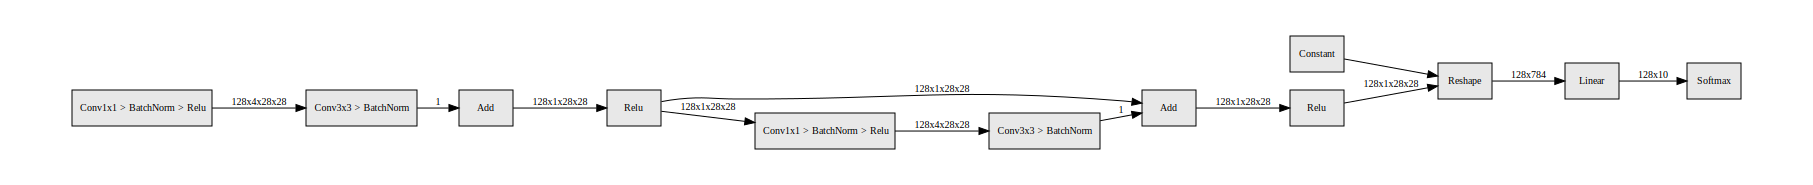

In [7]:
import hiddenlayer as hl
hl.build_graph(model, torch.zeros([128, 1, 28, 28]).to(device))

### Training

In [8]:
def compute_accuracy(model, data_loader):
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):            
        features = features.to(device)
        targets = targets.to(device)
        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100


start_time = time.time()
for epoch in range(num_epochs):
    model = model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.to(device)
        targets = targets.to(device)
        
        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))

    model = model.eval() # eval mode to prevent upd. batchnorm params during inference
    with torch.set_grad_enabled(False): # save memory during inference
        print('Epoch: %03d/%03d training accuracy: %.2f%%' % (
              epoch+1, num_epochs, 
              compute_accuracy(model, train_loader)))

    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/010 | Batch 000/469 | Cost: 2.6090
Epoch: 001/010 | Batch 050/469 | Cost: 0.4669
Epoch: 001/010 | Batch 100/469 | Cost: 0.4385
Epoch: 001/010 | Batch 150/469 | Cost: 0.2819
Epoch: 001/010 | Batch 200/469 | Cost: 0.3329
Epoch: 001/010 | Batch 250/469 | Cost: 0.2268
Epoch: 001/010 | Batch 300/469 | Cost: 0.2387
Epoch: 001/010 | Batch 350/469 | Cost: 0.3111
Epoch: 001/010 | Batch 400/469 | Cost: 0.4359
Epoch: 001/010 | Batch 450/469 | Cost: 0.3192
Epoch: 001/010 training accuracy: 91.40%
Time elapsed: 0.76 min
Epoch: 002/010 | Batch 000/469 | Cost: 0.2191
Epoch: 002/010 | Batch 050/469 | Cost: 0.3838
Epoch: 002/010 | Batch 100/469 | Cost: 0.1736
Epoch: 002/010 | Batch 150/469 | Cost: 0.3366
Epoch: 002/010 | Batch 200/469 | Cost: 0.2308
Epoch: 002/010 | Batch 250/469 | Cost: 0.3821
Epoch: 002/010 | Batch 300/469 | Cost: 0.2225
Epoch: 002/010 | Batch 350/469 | Cost: 0.2468
Epoch: 002/010 | Batch 400/469 | Cost: 0.3760
Epoch: 002/010 | Batch 450/469 | Cost: 0.3445
Epoch: 002/010 t

### Evaluation

In [9]:
print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader)))

Test accuracy: 92.11%


## ResNet with convolutional blocks for resizing

The following code implements the residual blocks with skip connections such that the input passed via the shortcut matches is resized to dimensions of the main path's output. Such a residual block is illustrated below:

![](https://github.com/DeepSE/deeplearning-models/blob/master/pytorch_ipynb/images/resnets/resnet-ex-1-2.png?raw=1)

In [10]:
##########################
### MODEL
##########################



class ConvNet(torch.nn.Module):

    def __init__(self, num_classes):
        super(ConvNet, self).__init__()
        
        #########################
        ### 1st residual block
        #########################
        # 28x28x1 => 14x14x4 
        self.conv_1 = torch.nn.Conv2d(in_channels=1,
                                      out_channels=4,
                                      kernel_size=(3, 3),
                                      stride=(2, 2),
                                      padding=1)
        self.conv_1_bn = torch.nn.BatchNorm2d(4)
                                    
        # 14x14x4 => 14x14x8
        self.conv_2 = torch.nn.Conv2d(in_channels=4,
                                      out_channels=8,
                                      kernel_size=(1, 1),
                                      stride=(1, 1),
                                      padding=0)   
        self.conv_2_bn = torch.nn.BatchNorm2d(8)
        
        # 28x28x1 => 14x14x8
        self.conv_shortcut_1 = torch.nn.Conv2d(in_channels=1,
                                               out_channels=8,
                                               kernel_size=(1, 1),
                                               stride=(2, 2),
                                               padding=0)   
        self.conv_shortcut_1_bn = torch.nn.BatchNorm2d(8)
        
        #########################
        ### 2nd residual block
        #########################
        # 14x14x8 => 7x7x16 
        self.conv_3 = torch.nn.Conv2d(in_channels=8,
                                      out_channels=16,
                                      kernel_size=(3, 3),
                                      stride=(2, 2),
                                      padding=1)
        self.conv_3_bn = torch.nn.BatchNorm2d(16)
                                    
        # 7x7x16 => 7x7x32
        self.conv_4 = torch.nn.Conv2d(in_channels=16,
                                      out_channels=32,
                                      kernel_size=(1, 1),
                                      stride=(1, 1),
                                      padding=0)   
        self.conv_4_bn = torch.nn.BatchNorm2d(32)
        
        # 14x14x8 => 7x7x32 
        self.conv_shortcut_2 = torch.nn.Conv2d(in_channels=8,
                                               out_channels=32,
                                               kernel_size=(1, 1),
                                               stride=(2, 2),
                                               padding=0)   
        self.conv_shortcut_2_bn = torch.nn.BatchNorm2d(32)

        #########################
        ### Fully connected
        #########################        
        self.linear_1 = torch.nn.Linear(7*7*32, num_classes)

        
    def forward(self, x):
        
        #########################
        ### 1st residual block
        #########################
        shortcut = x
        
        out = self.conv_1(x) # 28x28x1 => 14x14x4 
        out = self.conv_1_bn(out)
        out = F.relu(out)

        out = self.conv_2(out) # 14x14x4 => 714x14x8
        out = self.conv_2_bn(out)
        
        # match up dimensions using a linear function (no relu)
        shortcut = self.conv_shortcut_1(shortcut)
        shortcut = self.conv_shortcut_1_bn(shortcut)
        
        out += shortcut
        out = F.relu(out)
        
        #########################
        ### 2nd residual block
        #########################
        
        shortcut = out
        
        out = self.conv_3(out) # 14x14x8 => 7x7x16 
        out = self.conv_3_bn(out)
        out = F.relu(out)

        out = self.conv_4(out) # 7x7x16 => 7x7x32
        out = self.conv_4_bn(out)
        
        # match up dimensions using a linear function (no relu)
        shortcut = self.conv_shortcut_2(shortcut)
        shortcut = self.conv_shortcut_2_bn(shortcut)
        
        out += shortcut
        out = F.relu(out)
        
        #########################
        ### Fully connected
        #########################   
        logits = self.linear_1(out.view(-1, 7*7*32))
        probas = F.softmax(logits, dim=1)
        return logits, probas

    
torch.manual_seed(random_seed)
model = ConvNet(num_classes=num_classes)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

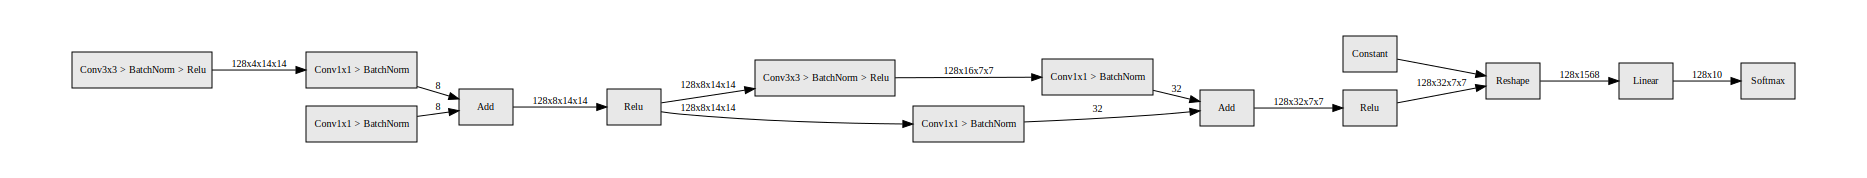

In [12]:
import hiddenlayer as hl
hl.build_graph(model, torch.zeros([128, 1, 28, 28]).to(device))

### Training

In [13]:
def compute_accuracy(model, data_loader):
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):            
        features = features.to(device)
        targets = targets.to(device)
        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100
    

for epoch in range(num_epochs):
    model = model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.to(device)
        targets = targets.to(device)
            
        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))

    model = model.eval() # eval mode to prevent upd. batchnorm params during inference
    with torch.set_grad_enabled(False): # save memory during inference
        print('Epoch: %03d/%03d training accuracy: %.2f%%' % (
              epoch+1, num_epochs, 
              compute_accuracy(model, train_loader)))

Epoch: 001/010 | Batch 000/469 | Cost: 2.3909
Epoch: 001/010 | Batch 050/469 | Cost: 0.4003
Epoch: 001/010 | Batch 100/469 | Cost: 0.2683
Epoch: 001/010 | Batch 150/469 | Cost: 0.1820
Epoch: 001/010 | Batch 200/469 | Cost: 0.1185
Epoch: 001/010 | Batch 250/469 | Cost: 0.0833
Epoch: 001/010 | Batch 300/469 | Cost: 0.0884
Epoch: 001/010 | Batch 350/469 | Cost: 0.0383
Epoch: 001/010 | Batch 400/469 | Cost: 0.0925
Epoch: 001/010 | Batch 450/469 | Cost: 0.0253
Epoch: 001/010 training accuracy: 97.77%
Epoch: 002/010 | Batch 000/469 | Cost: 0.1370
Epoch: 002/010 | Batch 050/469 | Cost: 0.0231
Epoch: 002/010 | Batch 100/469 | Cost: 0.0535
Epoch: 002/010 | Batch 150/469 | Cost: 0.0244
Epoch: 002/010 | Batch 200/469 | Cost: 0.1072
Epoch: 002/010 | Batch 250/469 | Cost: 0.0215
Epoch: 002/010 | Batch 300/469 | Cost: 0.0249
Epoch: 002/010 | Batch 350/469 | Cost: 0.0180
Epoch: 002/010 | Batch 400/469 | Cost: 0.0399
Epoch: 002/010 | Batch 450/469 | Cost: 0.0521
Epoch: 002/010 training accuracy: 98.37

### Evaluation

In [14]:
print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader)))

Test accuracy: 98.26%


## ResNet with convolutional blocks for resizing (using a helper class)

This is the same network as above but uses a `ResidualBlock` helper class.

In [15]:
class ResidualBlock(torch.nn.Module):

    def __init__(self, channels):
        
        super(ResidualBlock, self).__init__()
        self.conv_1 = torch.nn.Conv2d(in_channels=channels[0],
                                      out_channels=channels[1],
                                      kernel_size=(3, 3),
                                      stride=(2, 2),
                                      padding=1)
        self.conv_1_bn = torch.nn.BatchNorm2d(channels[1])
                                    
        self.conv_2 = torch.nn.Conv2d(in_channels=channels[1],
                                      out_channels=channels[2],
                                      kernel_size=(1, 1),
                                      stride=(1, 1),
                                      padding=0)   
        self.conv_2_bn = torch.nn.BatchNorm2d(channels[2])

        self.conv_shortcut_1 = torch.nn.Conv2d(in_channels=channels[0],
                                               out_channels=channels[2],
                                               kernel_size=(1, 1),
                                               stride=(2, 2),
                                               padding=0)   
        self.conv_shortcut_1_bn = torch.nn.BatchNorm2d(channels[2])

    def forward(self, x):
        shortcut = x
        
        out = self.conv_1(x)
        out = self.conv_1_bn(out)
        out = F.relu(out)

        out = self.conv_2(out)
        out = self.conv_2_bn(out)
        
        # match up dimensions using a linear function (no relu)
        shortcut = self.conv_shortcut_1(shortcut)
        shortcut = self.conv_shortcut_1_bn(shortcut)
        
        out += shortcut
        out = F.relu(out)

        return out

In [16]:
##########################
### MODEL
##########################



class ConvNet(torch.nn.Module):

    def __init__(self, num_classes):
        super(ConvNet, self).__init__()
        
        self.residual_block_1 = ResidualBlock(channels=[1, 4, 8])
        self.residual_block_2 = ResidualBlock(channels=[8, 16, 32])
    
        self.linear_1 = torch.nn.Linear(7*7*32, num_classes)

        
    def forward(self, x):

        out = self.residual_block_1.forward(x)
        out = self.residual_block_2.forward(out)
         
        logits = self.linear_1(out.view(-1, 7*7*32))
        probas = F.softmax(logits, dim=1)
        return logits, probas

    
torch.manual_seed(random_seed)
model = ConvNet(num_classes=num_classes)

model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

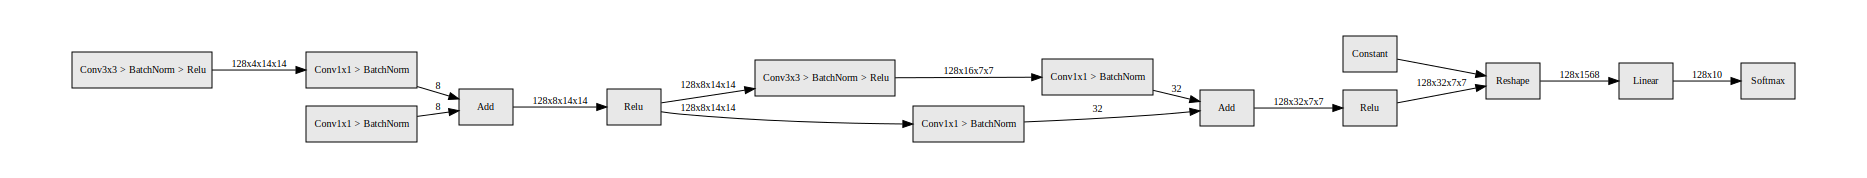

In [18]:
import hiddenlayer as hl
hl.build_graph(model, torch.zeros([128, 1, 28, 28]).to(device))

### Training

In [19]:
def compute_accuracy(model, data_loader):
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):            
        features = features.to(device)
        targets = targets.to(device)
        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100
    

for epoch in range(num_epochs):
    model = model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.to(device)
        targets = targets.to(device)
            
        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_dataset)//batch_size, cost))

    model = model.eval() # eval mode to prevent upd. batchnorm params during inference
    with torch.set_grad_enabled(False): # save memory during inference
        print('Epoch: %03d/%03d training accuracy: %.2f%%' % (
              epoch+1, num_epochs, 
              compute_accuracy(model, train_loader)))

Epoch: 001/010 | Batch 000/468 | Cost: 0.0125
Epoch: 001/010 | Batch 050/468 | Cost: 0.0768
Epoch: 001/010 | Batch 100/468 | Cost: 0.0672
Epoch: 001/010 | Batch 150/468 | Cost: 0.0391
Epoch: 001/010 | Batch 200/468 | Cost: 0.0432
Epoch: 001/010 | Batch 250/468 | Cost: 0.0469
Epoch: 001/010 | Batch 300/468 | Cost: 0.0487
Epoch: 001/010 | Batch 350/468 | Cost: 0.0604
Epoch: 001/010 | Batch 400/468 | Cost: 0.0381
Epoch: 001/010 | Batch 450/468 | Cost: 0.0105
Epoch: 001/010 training accuracy: 98.49%
Epoch: 002/010 | Batch 000/468 | Cost: 0.0434
Epoch: 002/010 | Batch 050/468 | Cost: 0.0735
Epoch: 002/010 | Batch 100/468 | Cost: 0.0339
Epoch: 002/010 | Batch 150/468 | Cost: 0.0281
Epoch: 002/010 | Batch 200/468 | Cost: 0.0101
Epoch: 002/010 | Batch 250/468 | Cost: 0.0378
Epoch: 002/010 | Batch 300/468 | Cost: 0.0542
Epoch: 002/010 | Batch 350/468 | Cost: 0.1047
Epoch: 002/010 | Batch 400/468 | Cost: 0.0349
Epoch: 002/010 | Batch 450/468 | Cost: 0.0425
Epoch: 002/010 training accuracy: 98.25

### Evaluation

In [20]:
print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader)))

Test accuracy: 98.17%


In [21]:
%watermark -iv

torch 1.5.1+cu101
numpy 1.18.5

